---  
title: "状態遷移行列に関するノートブック"  
author: "Naoya Ozaki"  
date: "25 November 2025"  
output: "state_transition_matrix"  

---  

# 状態遷移行列に関するノートブック

## 1. 二体問題の場合の状態遷移行列
二体問題の運動方程式である
$$
\frac{d^2\boldsymbol{r}}{dt^2} = -\frac{GM}{r^3}\boldsymbol{r}
$$
および
$$
\frac{d}{dt}\Phi(t,t_0) = \begin{bmatrix} O & I\\
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{r}} & O
\end{bmatrix}\Phi(t,t_0)
$$
を`scipy.integrate`を用いて伝播する．但し，$\boldsymbol{r}=[x,y,z]$は中心天体に対する宇宙機の3次元位置ベクトルである．$r$は$\boldsymbol{r}$の大きさ（ノルム）を表す．$GM$は中心天体の重力定数である．また，
$$
\frac{\partial \boldsymbol{a}}{\partial \boldsymbol{r}} = -\frac{GM}{r^3}\left(I-\frac{3\boldsymbol{r}\boldsymbol{r}^T}{r^2}\right)
$$
である．

In [1]:
# Pythonのモジュールをインポート
import numpy as np # 数値計算ライブラリ
from scipy.integrate import odeint # 常微分方程式を解くライブラリ

# 二体問題の運動方程式
def func(x, t):
    """二体問題の運動方程式

    Args:
        x (np.ndarray): 状態量 (位置＋速度) + STM
        t (float): 時刻

    Returns:
        np.ndarray: 状態量の時間微分
    """
    GM = 398600.4354360959 # 地球の重力定数, km3/s2
    r = np.linalg.norm(x[0:3])
    stm = x[6:42].reshape((6,6))
    dadr = -GM/(r**3)*(np.identity(3) - 3.0*np.outer(x[0:3],x[0:3])/(r**2))
    dstmdt = np.dot(np.block([[np.zeros((3,3)),np.identity(3)],[dadr, np.zeros((3,3))]]), stm)
    dxdt = np.block([x[3:6], 
                     -GM/(r**3)*x[0:3],
                     dstmdt.flatten()])
    return dxdt 

# 微分方程式の初期条件
x0 = np.array([10000, 0, 0, 0, 7, 0])
stm0 = np.identity(6)
t  = np.linspace(0, 86400, 1000) # 1日分 軌道伝播

# 微分方程式の数値計算
sol = odeint(func, np.block([x0, stm0.flatten()]), t)


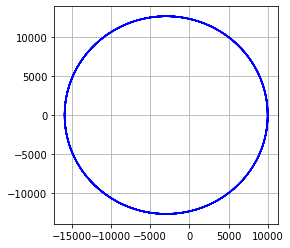

In [2]:
# 結果の描画
import matplotlib.pyplot as plt # 描画ライブラリ

# 描画
plt.plot(sol[:, 0],sol[:, 1], 'b')
plt.grid() # 格子をつける
plt.gca().set_aspect('equal') # グラフのアスペクト比を揃える
plt.show()